## 手写数字识别实战

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import torchvision
from matplotlib import pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### 画图辅助 function

In [2]:
# loss curve 可视化loss下降曲线
def plot_curve(data):
    fig = plt.figure()
    plt.plot(range(len(data)), data, color='blue')
    plt.legend(['value'], loc='upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()

# visualization of result 可视化图片
def plot_image(img, label, name):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1) # 创建多个子图,2 rows 3 cloums ,i+1 is index
        plt.tight_layout()  # 用于自动调整子图参数以提供指定的填充
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none') # draw heatmap
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([]) # 不显示横坐标
        plt.yticks([])
    plt.show()

# one_hot encode for label
def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth) #返回一个形状为为size,类型为torch.dtype，里面的每一个值都是0的tensor
    idx = torch.LongTensor(label).view(-1, 1)
    out.scatter_(dim=1, index=idx, value=1)
    return out

In [24]:
one_hot(torch.tensor([0,1,2,3]))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

### 读取数据

torch.utils 内置 MNIST 数据集，可以直接下载调用

In [3]:
batch_size = 512 # 一次处理512个28*28像素的图片

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True) # 获取训练集

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=False) # 获取测试集

# torchvision.transforms.Normalize正则化：为什么呢？因为神经网络接受的数据集最好是在0附近均匀的分布.
# 而minst图片数据集的像素值都是大于0的，在0的右侧分布,因此减去0.1307平均值再除以0.3081标准差，让模型性能更好

torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


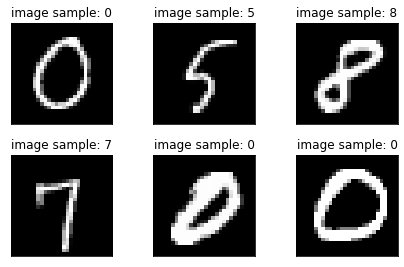

In [4]:
# 测试一个实例
x, y = next(iter(train_loader)) # iter()函数生成一个迭代器，接受的值是：任何支持迭代的集合对象，next（）函数返回迭代器里的下一个项目
print(x.shape, y.shape, x.min(), x.max())
plot_image(x, y, 'image sample')

### 建立网络

In [5]:
class Net(nn.Module): # 继承 pytorch 自带类

    def __init__(self):
        super(Net, self).__init__()
        # 实现3层网络 xw+b
        # 此处为每层权重初始化
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # 前向传播函数，计算时会接受一张图片
        # h1 = relu(xw1+b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2+b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3+b3
        # 最后一层更具实际做调整，这里就用简单的均方误差作为损失函数
        x = self.fc3(x)
        return x

### 训练模型

In [6]:
#实例化一个网络对象
net = Net()
#构建优化器
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # 随机梯度下降，优化的就是net实例里的模型参数
#创建一个空列表记录每个batch的损失值
train_loss = [] 

In [26]:
for epoch in range(3): #对整个数据集迭代3次
    for batch_idx, (x, y) in enumerate(train_loader): # train_loader可迭代对象里的元素是一对对(x,y)pair
        # x: [b, 1, 28, 28], y: [b]
        # 而net只能接受的是[batch,28*28]这样的2维输入，所以要将[512, 1, 28, 28]打平成[512,784]
        # [b, 1, 28, 28] => [b, 784]
        x = x.view(x.size(0), 28*28) # x.size(0)取得就是第一个元素，512

        # 将打平后的样本属性输入进net() => [b, 10]
        out = net(x) #得到的out就是预测值
        y_onehot = one_hot(y) #通过one_hot函数将y也变成onehot格式 [b, 10]
        
        # 接下来我们希望，out 接近于y_onehot
        loss = F.mse_loss(out, y_onehot)

        optimizer.zero_grad()  # 梯度清零
        loss.backward() #计算梯度
        # w' = w - lr*grad
        optimizer.step() #更新梯度

        train_loss.append(loss.item())  #将loss值存进列表中，方便之后画图
        # 每个10个batch打印一次loss
        if batch_idx % 10==0:
            print(epoch, batch_idx, loss.item())

0 0 0.10759361833333969
0 10 0.09444443136453629
0 20 0.08584798872470856
0 30 0.08049176633358002
0 40 0.07488486915826797
0 50 0.07051582634449005
0 60 0.06614620238542557
0 70 0.06287319958209991
0 80 0.05842266231775284
0 90 0.05630342289805412
0 100 0.05388900637626648
0 110 0.05114709585905075
1 0 0.04924849420785904
1 10 0.04761557653546333
1 20 0.045320965349674225
1 30 0.047775667160749435
1 40 0.04476300626993179
1 50 0.04560505226254463
1 60 0.0417795293033123
1 70 0.04252726957201958
1 80 0.03895410895347595
1 90 0.04237261414527893
1 100 0.04057879000902176
1 110 0.03942284733057022
2 0 0.038189422339200974
2 10 0.03642185032367706
2 20 0.03683634102344513
2 30 0.037364523857831955
2 40 0.03663918375968933
2 50 0.04003308340907097
2 60 0.03772184997797012
2 70 0.03536868095397949
2 80 0.03563985973596573
2 90 0.03472227603197098
2 100 0.03406861796975136
2 110 0.0336172953248024


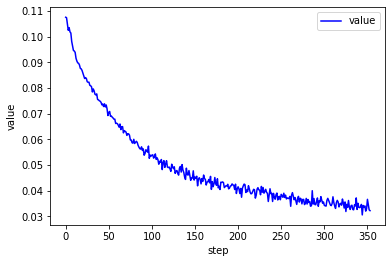

In [27]:
plot_curve(train_loss)
#整个循环结束后，会得到最好的模型参数，但这并不是衡量模型性能的指标，要用到在测试集上的准确度

### 评估模型

In [28]:
total_correct = 0  #初始化变量，用来记录每个batch中有多少是预测正确的
for x,y in test_loader:
    x  = x.view(x.size(0), 28*28)
    out = net(x)
    pred = out.argmax(dim=1) #返回out中第二个维度的最大值的索引,将out[batch,10]转化成pred[batch]形状
    # pred.eq(y)比较出哪些是预测正确的，用sum()加起来，再用float()转化成浮点型,还是tensor格式，用item（）将其取出里面的数值
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

total_num = len(test_loader.dataset) #统计总共有多少个样本
acc = total_correct / total_num #compute acc
print('test acc:', acc)

test acc: 0.8824


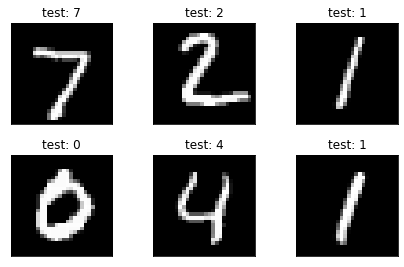

In [29]:
# 可视化test的结果
x, y = next(iter(test_loader))
out = net(x.view(x.size(0), 28*28))
pred = out.argmax(dim=1)
plot_image(x, pred, 'test')